<a href="https://colab.research.google.com/github/gb999/LuaLuaLua/blob/hyperopti-lstm-and-confidence/LuaLuaLua.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting the data

1. To download competition data from Kaggle the rules of the competition have to be accepted [here](https://www.kaggle.com/competitions/nlp-getting-started/data), by joining the competition.

2. After that, an API key has to be obtained.
Follow these [instructions](https://www.kaggle.com/docs/api) to do so.

3. Create a new secret named `kaggle.json` in Google Colab, copy the contents of the downloaded file into the value field. Enable Notebook access, and you are ready to go.





In [2]:
from google.colab import userdata
import json, os
kaggle_path = '/root/.config/kaggle'
kaggle_json = userdata.get('kaggle.json')
os.makedirs(kaggle_path, exist_ok=True)

with open(kaggle_path + '/kaggle.json', 'w') as f:
    f.write(kaggle_json)

os.chmod(kaggle_path + '/kaggle.json', 0o600)


In [3]:
!pip install kaggle --quiet
!kaggle competitions download -c nlp-getting-started -q
!unzip -o nlp-getting-started.zip

Archive:  nlp-getting-started.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


# Processing the data



In [4]:
# Load DataFrames
import pandas as pd
from collections import Counter
import re
import matplotlib.pyplot as plt

train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

## Cleaning the data





Text cleaning is an essential preprocessing step in word vectorization, as it removes noise that can interfere with meaningful analysis. This often includes eliminating stopwords and punctuation, which don't add significant value to word embeddings, and converting text to lowercase to ensure consistency across words. By focusing on essential terms, this cleaning process enhances the quality and accuracy of word vector models.

*Stopwords are for example: of, for, with haven't, by...*

Stopwords are obtained from the 'nltk' module.

### Steps:
1. Replace links with the word '[link]'
1. Keep only letters and square brackets.
1. Remove stopwords



In [5]:
!pip install nltk --quiet

In [6]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
print(stop_words)

{'hers', 'any', 'yourselves', "she's", 'am', "wasn't", 'her', 'because', 'who', 'all', 'there', 'before', 'his', 'theirs', 'through', 'under', 'own', 'she', 'herself', "you'll", 'had', 'and', 'over', 'where', 'more', 'doing', 'about', "should've", 'but', 'further', "doesn't", 'mightn', "you're", 'themselves', "hasn't", 'against', "mustn't", 'just', 't', 'by', 'itself', 'didn', 'off', 'up', 'out', 'nor', "shouldn't", 'on', 'our', 'wasn', 'at', 'is', "that'll", 'so', 'too', "wouldn't", 'if', 'until', "it's", 're', 'ain', 'above', 'below', 'the', 'were', 'that', 'down', 'only', 'been', 'again', 'shan', 'haven', 'needn', 'ourselves', 'i', 'my', 'was', 'ours', 'such', 'can', 'both', 'your', 'did', 'which', 'wouldn', 'them', 'they', 'once', 'hadn', "you'd", 'o', 'be', 'some', "you've", 'being', 'he', 'does', "mightn't", 'during', "hadn't", 'from', "couldn't", 'a', 'll', 'isn', 'into', 'few', "haven't", 'this', 'very', 'what', 'has', "don't", 'himself', 'are', 'or', "weren't", 'whom', "didn't

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [7]:
# Remove or replace links in a string.
def remove_links(text, replace=''):
  text = re.sub(r'http\S+', replace, text)
  return text

def remove_retweets(text):
    return re.sub(r'^RT\s+@\w+', '', text, flags=re.IGNORECASE)

In [8]:
import re
import string

# Replaces links and removes retweets and stopwords from a tweet
def clean_tweet(tweet, remove_stopwords=True, stop_words = set(), replace_links = ''):
  tweet = remove_links(tweet, replace_links)
  tweet = remove_retweets(tweet)
  words = re.findall(r"[A-Za-z\[\]]+", tweet.lower())  # Keep letters and square brackets

  if remove_stopwords:
    words = [word for word in words if word not in stop_words]

  return ' '.join(words)

def clean_tweets(lines, remove_stopwords=True, stop_words=set()):
  cleaned_lines = []
  for line in lines:
    cleaned_line = clean_tweet(line, remove_stopwords, stop_words)
    cleaned_lines.append(cleaned_line)

  return cleaned_lines

## Process the whole dataset
The Kaggle test data doesn't provide labeled targets in the test data, so we sample 10% of the trainig data for our own testing and visualizing a confusion matrix.


In [9]:
train_df['text'] = train_df['text'].apply(lambda t: clean_tweet(t, remove_stopwords=True, stop_words= stop_words, replace_links="[link]"))
test_df['text'] = test_df['text'].apply(lambda t: clean_tweet(t, remove_stopwords=True, stop_words= stop_words, replace_links="[link]"))

train_df_conf_mx = train_df.sample(frac=0.1)
train_df = train_df.loc[~train_df.index.isin(train_df_conf_mx.index)].reset_index(drop=True)

print(train_df.head())

   id keyword location                                               text  \
0   1     NaN      NaN       deeds reason earthquake may allah forgive us   
1   4     NaN      NaN              forest fire near la ronge sask canada   
2   6     NaN      NaN  people receive wildfires evacuation orders cal...   
3   7     NaN      NaN  got sent photo ruby alaska smoke wildfires pou...   
4  10     NaN      NaN  flood disaster heavy rain causes flash floodin...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  


# Visualization


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6852 entries, 0 to 6851
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        6852 non-null   int64 
 1   keyword   6796 non-null   object
 2   location  4571 non-null   object
 3   text      6852 non-null   object
 4   target    6852 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 267.8+ KB


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


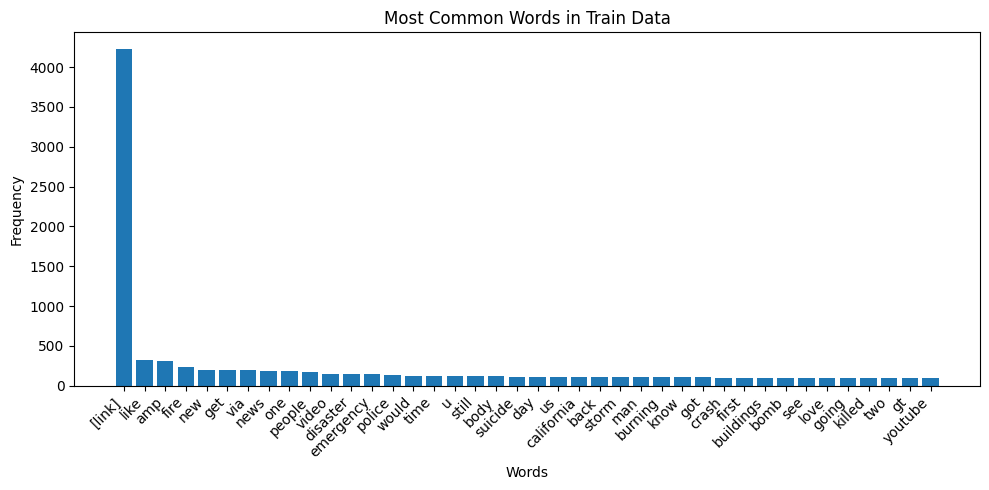

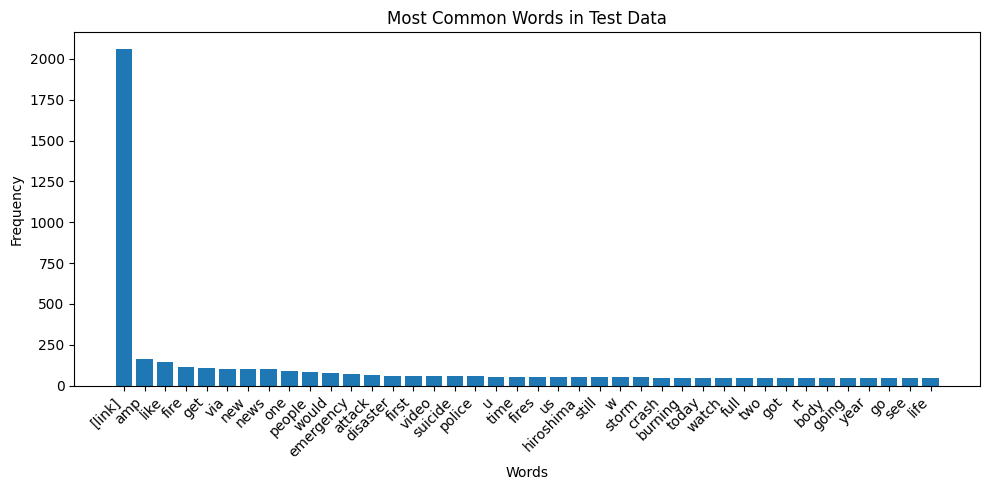

In [10]:
def get_most_common_words(df, text_column, n=40):
    # Combine all text into a single string
    text = " ".join(df[text_column].astype(str).tolist())
    words = text.split()
    word_counts = Counter(words)
    return word_counts.most_common(n)

def plot_most_common_words(common_words, title):
  words, counts = zip(*common_words)
  plt.figure(figsize=(10, 5))
  plt.bar(words, counts)
  plt.title(title)
  plt.xlabel("Words")
  plt.ylabel("Frequency")
  plt.xticks(rotation=45, ha='right')
  plt.tight_layout()
  plt.show()

# Get most common words
train_common_words = get_most_common_words(train_df, 'text')
test_common_words = get_most_common_words(test_df, 'text')

#Show dataframe info
train_df.info()
print("\n")
test_df.info()

# Diagrams
plot_most_common_words(train_common_words, "Most Common Words in Train Data")
plot_most_common_words(test_common_words, "Most Common Words in Test Data")

# Observations
`[link]` became the most common word, so we might as well remove it.

In [11]:
train_df['text'] = train_df['text'].apply(lambda t: clean_tweet(t, remove_stopwords=True, stop_words= stop_words, replace_links=""))
test_df['text'] = test_df['text'].apply(lambda t: clean_tweet(t, remove_stopwords=True, stop_words= stop_words, replace_links=""))


# Encoding the data
We use the GloVe model for encoding the data.

In [12]:
!wget -nc -q http://nlp.stanford.edu/data/glove.6B.zip
!unzip -n glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       




## GloVe
GloVe, which stands for Global Vectors for Word Representation, is a popular word embedding technique that captures semantic relationships between words in a vector space. This model is a straightforward word-vectorization model, which uses a 50-dimensional vector for each word. In this model (as in other word-vector models), each word is represented by an
n-dimensional vector. The "distance" between vectors represents the similarity between words. Distance is calculated using the Pythagorean theorem, as the square root of the sum of squared differences. For instance, the distance between words like "mug" and "cup" is small, as they are similar and can often be used interchangeably in a sentence. However, words like "tractor" and "skyscraper" are positioned far apart in the vector space due to their distinct meanings.

There are, of course, other word-to-vector models, but we chose GloVe for our initial attempt due to its simplicity and ease of use. We will train our first prediction model using this. Later, to potentially improve accuracy, we may switch to Word2Vec, which can use vectors with dimensions of 100, 200, or even 300 for greater precision.

## GloVe as transfer learning
When using GloVe for transfer, we initialize the model's embedding layer with GloVe vectors rather than training the word embeddings from random initialization. This way the model has a foundation for understanding the relationships between words, which helps us reduce training time significantly and lets us focus on the classification aspect of the task.

In [13]:
import numpy as np
# Glove_model is a word-vector dictionary
def load_glove_model(file_path):
  glove_model = {}
  with open(file_path, 'r', encoding='utf-8') as f:
    # assign a vector to each word
    for line in f:
      values = line.split(' ')
      word = values[0]
      vector = np.asarray(values[1:], dtype='float32')
      glove_model[word] = vector
  return glove_model

In [14]:
glove_path = 'glove.6B.100d.txt'
glove_model = load_glove_model(glove_path)

# Get vector for word 'python'
print(f"Here's the word python in vector representation:\n {glove_model['python']}")
print(f"length: {len(glove_model['python'])}")

Here's the word python in vector representation:
 [ 0.24934    0.68318   -0.044711  -1.3842    -0.0073079  0.651
 -0.33958   -0.19785   -0.33925    0.26691   -0.033062   0.15915
  0.89547    0.53999   -0.55817    0.46245    0.36722    0.1889
  0.83189    0.81421   -0.11835   -0.53463    0.24158   -0.038864
  1.1907     0.79353   -0.12308    0.6642    -0.77619   -0.45713
 -1.054     -0.20557   -0.13296    0.12239    0.88458    1.024
  0.32288    0.82105   -0.069367   0.024211  -0.51418    0.8727
  0.25759    0.91526   -0.64221    0.041159  -0.60208    0.54631
  0.66076    0.19796   -1.1393     0.79514    0.45966   -0.18463
 -0.64131   -0.24929   -0.40194   -0.50786    0.80579    0.53365
  0.52732    0.39247   -0.29884    0.009585   0.99953   -0.061279
  0.71936    0.32901   -0.052772   0.67135   -0.80251   -0.25789
  0.49615    0.48081   -0.68403   -0.012239   0.048201   0.29461
  0.20614    0.33556   -0.64167   -0.64708    0.13377   -0.12574
 -0.46382    1.3878     0.95636   -0.067869 

# Building the model

Below the data is prepared for the training:
- We chose a vocabulary size of 20000, it represents the 20000 most frequent words in the dataset, this size should be enough for a small dataset like this.
- The tweets are tokenized into words

The distribution of sequence lengths is plotted, so we can choose an adequate maximum length.




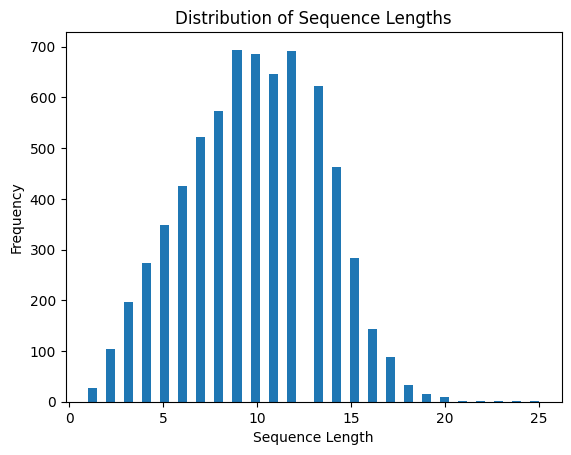

In [15]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

# Define parameters
vocab_size = 20000 # This is the number of unique words in the dataset, which the model will consider
embedding_dim = 100  # Dimension of GloVe embeddings
oov_token = "[OOV]"  # Token for out-of-vocabulary words

# Tokenize the data
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(train_df['text'])

# Convert text to sequences
train_sequences = tokenizer.texts_to_sequences(train_df['text'])
test_sequences = tokenizer.texts_to_sequences(test_df['text'])
train_df_conf_mx_sequences = tokenizer.texts_to_sequences(train_df_conf_mx['text'])

lengths = [len(seq) for seq in train_sequences]
plt.hist(lengths, bins=50)
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.title('Distribution of Sequence Lengths')
plt.show()


In [16]:
max_length = int(np.percentile(lengths, 99))  # Max number of words in a sequence
print(max_length)

17


99% of sequences is 17 words or less in length, so 17 words should be a good choice as a maximum sequence length.

The shorter sequences are padded and the longer ones are truncated so every sequence is the same length.

In [17]:
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post', truncating='post')
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post', truncating='post')
train_df_conf_mx_padded = pad_sequences(train_df_conf_mx_sequences, maxlen = max_length, padding = 'post', truncating='post')

A mapping of the 20000 most common word indices to word vectors is created in a matrix form. This will be passed to the embedding layer.

In [18]:
# Create embedding matrix
word_index = tokenizer.word_index
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in word_index.items():
    if i < vocab_size:
        embedding_vector = glove_model.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

train_labels = train_df['target'].values

## The model
This model uses an embedding layer with GloVe loaded. The Bidirectional LSTM cells are for capturing context in the tweets. A droput layer is used to reduce overfitting. The output is a number from 0 to 1, above 0.5 we interpret the predicition as a 'disaster', below as a 'non-disaster'. We use keras tuner to hyperparameter optimize the model

In [21]:
!pip install keras-tuner --quiet

In [19]:
from tensorflow import keras

In [24]:
import keras_tuner as kt
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, GlobalMaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.regularizers import l2

# Function to create the model with tunable hyperparameters
def build_model(hp):
    model = Sequential([
        Embedding(input_dim=vocab_size,
                  output_dim=embedding_dim,
                  weights=[embedding_matrix],
                  trainable=False),  # We can freeze the embedding layer, as it's pretrained

        # Hyperparameter tuning for the number of LSTM units and dropout rate
        Bidirectional(LSTM(units=hp.Int('lstm_units', min_value=64, max_value=256, step=64),
                            return_sequences=True,
                            dropout=hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1),
                            recurrent_dropout=hp.Float('recurrent_dropout_rate', min_value=0.1, max_value=0.5, step=0.1),
                            kernel_regularizer=l2(hp.Float('l2_strength', min_value=1e-5, max_value=1e-3, step=1e-5)))),

        GlobalMaxPooling1D(),

        Dense(64, activation='relu', kernel_regularizer=l2(1e-4)),
        Dropout(0.5),

        Dense(1, activation='sigmoid', kernel_regularizer=l2(1e-4))
    ])

    # Hyperparameter tuning for the optimizer's learning rate
    model.compile(optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-3, step=1e-5)),
                  loss='binary_crossentropy',
                  metrics=['accuracy', Precision(), Recall()])

    return model

# Create the tuner object
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',  # Metric to optimize
    max_epochs=10,
    factor=3,
    directory='hyperparameter_tuning',
    project_name='text_classification_tuning'
)

# Add ReduceLROnPlateau and EarlyStopping callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Start the hyperparameter search
tuner.search(
    train_padded,
    train_labels,
    validation_split=0.2,
    epochs=10,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr]  # Including ReduceLROnPlateau here
)



# Get summary of results
tuner.results_summary()


Trial 30 Complete [00h 02m 44s]
val_accuracy: 0.8212983012199402

Best val_accuracy So Far: 0.8278628587722778
Total elapsed time: 00h 39m 59s
Epoch 1/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 20s 97ms/step - accuracy: 0.8078 - loss: 0.5500 - precision: 0.8124 - recall: 0.7083 - val_accuracy: 0.8155 - val_loss: 0.4838 - val_precision: 0.8377 - val_recall: 0.7469 - learning_rate: 8.2000e-04
Epoch 2/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 12s 72ms/step - accuracy: 0.8092 - loss: 0.5152 - precision: 0.8012 - recall: 0.6908 - val_accuracy: 0.8155 - val_loss: 0.4867 - val_precision: 0.8792 - val_recall: 0.6981 - learning_rate: 8.2000e-04
Epoch 3/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 21s 73ms/step - accuracy: 0.8152 - loss: 0.4874 - precision: 0.8041 - recall: 0.7244 - val_accuracy: 0.8147 - val_loss: 0.4713 - val_precision: 0.8363 - val_recall: 0.7469 - learning_rate: 8.2000e-04
Epoch 4/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 14s 81ms/step - accuracy: 0.8192 - loss: 0.4767 - precision: 0.8217 - recall: 0.7115 - val_accura

AttributeError: 'HyperbandOracle' object has no attribute 'results'

In [28]:
tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values

{'lstm_units': 256,
 'dropout_rate': 0.1,
 'recurrent_dropout_rate': 0.5,
 'l2_strength': 0.0009500000000000001,
 'learning_rate': 0.0008200000000000001,
 'tuner/epochs': 4,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 1,
 'tuner/round': 0}

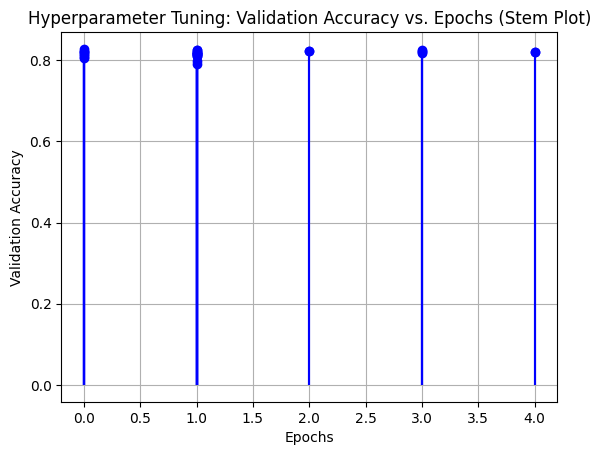

In [37]:
import matplotlib.pyplot as plt

# Get trial accuracies and epochs (same as before)
best_trials = tuner.oracle.get_best_trials(num_trials=len(tuner.oracle.trials.keys()))
trial_accuracies = [trial.score for trial in best_trials]
trial_epochs = [trial.best_step for trial in best_trials]

# Create stem plot
plt.stem(trial_epochs, trial_accuracies, linefmt='b-', markerfmt='bo', basefmt=' ')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.title('Hyperparameter Tuning: Validation Accuracy vs. Epochs (Stem Plot)')
plt.grid(True)
plt.show()

import pandas as pd

# Extract relevant data for the CSV
results_data = []
for trial_id, trial_details in tuner.oracle.trials.items():
    results_data.append({
        'trial_id': trial_id,
        'score': trial_details.score,
        'best_step': trial_details.best_step,
        **trial_details.hyperparameters.values # Store values of hyperparameters
    })

# Create DataFrame and write to CSV
results_df = pd.DataFrame(results_data)
results_df.to_csv('hyperparameter_tuning_results.csv', index=False)

In [51]:
# Retrieve the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Optionally, retrain or fine-tune the best model
history_stage2 = best_model.fit(
    train_padded,
    train_labels,
    validation_split=0.2,
    epochs=10,  # Fine-tuning phase
    batch_size=32,
    callbacks=[early_stopping, reduce_lr]  # Again, including ReduceLROnPlateau for fine-tuning
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


172/172 ━━━━━━━━━━━━━━━━━━━━ 20s 93ms/step - accuracy: 0.8002 - loss: 0.5614 - precision: 0.8062 - recall: 0.6821 - val_accuracy: 0.8220 - val_loss: 0.4939 - val_precision: 0.9206 - val_recall: 0.6745 - learning_rate: 8.2000e-04
Epoch 2/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 19s 83ms/step - accuracy: 0.8066 - loss: 0.5114 - precision: 0.8038 - recall: 0.6973 - val_accuracy: 0.8206 - val_loss: 0.4690 - val_precision: 0.8652 - val_recall: 0.7264 - learning_rate: 8.2000e-04
Epoch 3/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 20s 80ms/step - accuracy: 0.8169 - loss: 0.4844 - precision: 0.8242 - recall: 0.7042 - val_accuracy: 0.8206 - val_loss: 0.4618 - val_precision: 0.8736 - val_recall: 0.7170 - learning_rate: 8.2000e-04


## Evaluation
Below we observe the performance of the model from multiple aspects.

### Predictions
Let's see some example predictions

In [52]:
# Predict on test data
test_predictions = model.predict(test_padded)

# Convert probabilities to binary predictions
test_df['predicted_target'] = (test_predictions > 0.5).astype(int)

# Map predictions to human-readable labels
label_mapping = {0: "Not Disaster", 1: "Disaster"}
test_df['predicted_label'] = test_df['predicted_target'].map(label_mapping)

# Display input text and predictions
readable_predictions = test_df[['id', 'text', 'predicted_label']]

# Show a few examples
print(readable_predictions.head(20))

# Save to a CSV for further review
readable_predictions.to_csv('predictions_readable.csv', index=False)



102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step
    id                                               text predicted_label
0    0                        happened terrible car crash        Disaster
1    2  heard earthquake different cities stay safe ev...        Disaster
2    3  forest fire spot pond geese fleeing across str...        Disaster
3    9              apocalypse lighting spokane wildfires        Disaster
4   11                typhoon soudelor kills china taiwan        Disaster
5   12                                 shaking earthquake        Disaster
6   21   probably still show life arsenal yesterday eh eh    Not Disaster
7   22                                                hey    Not Disaster
8   27                                           nice hat    Not Disaster
9   29                                               fuck    Not Disaster
10  30                                          like cold    Not Disaster
11  35                                         nooooooooo    Not Disas

# Confidence level
These results are promising, but it would be useful to know how sure our model is in its prediction. To achieve this, we use the Monte Carlo Dropout Prediction technique.

In [80]:
import numpy as np
import pandas as pd
import tensorflow as tf

# Define the function for Monte Carlo Dropout during inference
def predict_with_uncertainty(model, input_data, n_iter=100):
    # Decorate the function with tf.function for better performance
    @tf.function
    def predict_fn(inputs):
        return model(inputs, training=True)  # Ensure dropout is active during inference

    # Collect multiple stochastic predictions
    predictions = []
    for _ in range(n_iter):
        # Perform a forward pass to get predictions with dropout enabled
        pred = predict_fn(input_data).numpy()  # Convert TensorFlow tensor to NumPy array
        predictions.append(pred)

    # Convert predictions to a NumPy array for further calculations
    predictions = np.array(predictions)

    # Calculate mean and standard deviation across the predictions
    mean_predictions = np.mean(predictions, axis=0)  # Mean of the predictions
    uncertainties = np.std(predictions, axis=0)      # Standard deviation as uncertainty

    return mean_predictions, uncertainties

# Predict on test data with Monte Carlo Dropout
n_iterations = 100  # Number of stochastic forward passes to estimate uncertainty
mean_predictions, uncertainties = predict_with_uncertainty(model, test_padded, n_iter=n_iterations)


# Convert probabilities to binary predictions based on mean prediction
test_df['predicted_target'] = (mean_predictions > 0.5).astype(int)

# Map predictions to human-readable labels
label_mapping = {0: "Not Disaster", 1: "Disaster"}
test_df['predicted_label'] = test_df['predicted_target'].map(label_mapping)

# Add uncertainty as a confidence level (1 - uncertainty)
test_df['confidence'] = 1 - uncertainties  # Higher uncertainty means lower confidence

# Display the relevant columns for review
readable_predictions = test_df[['id', 'text', 'predicted_label', 'confidence']]

# Show the first 20 examples for review
print(readable_predictions.head(20))

# Save to a CSV for further review
readable_predictions.to_csv('predictions_with_uncertainty.csv', index=False)


    id                                               text predicted_label  \
0    0                        happened terrible car crash        Disaster   
1    2  heard earthquake different cities stay safe ev...        Disaster   
2    3  forest fire spot pond geese fleeing across str...        Disaster   
3    9              apocalypse lighting spokane wildfires        Disaster   
4   11                typhoon soudelor kills china taiwan        Disaster   
5   12                                 shaking earthquake        Disaster   
6   21   probably still show life arsenal yesterday eh eh    Not Disaster   
7   22                                                hey    Not Disaster   
8   27                                           nice hat    Not Disaster   
9   29                                               fuck    Not Disaster   
10  30                                          like cold    Not Disaster   
11  35                                         nooooooooo    Not Disaster   

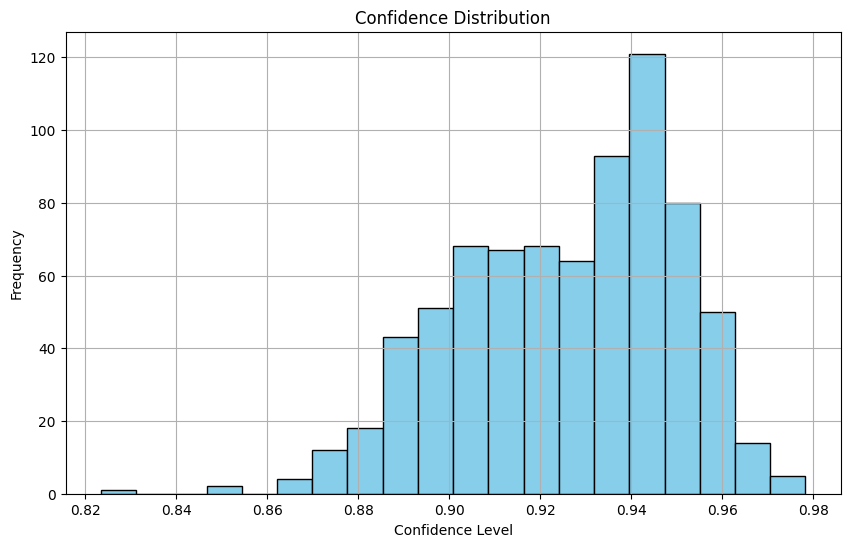

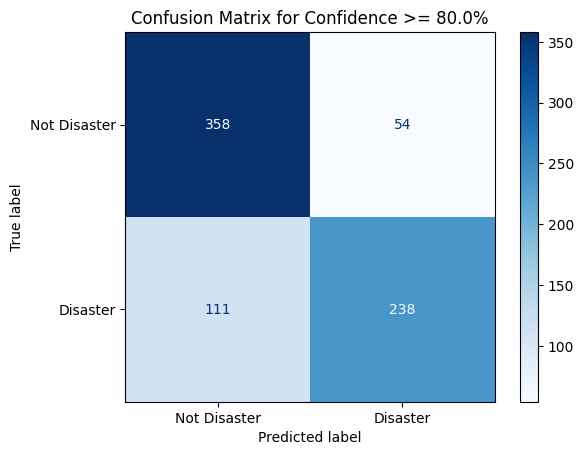

In [88]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn import metrics

# Define the function for Monte Carlo Dropout during inference
def predict_with_uncertainty(model, input_data, n_iter=100):
    @tf.function
    def predict_fn(inputs):
        return model(inputs, training=True)  # Enable dropout during inference

    # Collect predictions
    predictions = []
    for _ in range(n_iter):
        pred = predict_fn(input_data).numpy()  # Convert to NumPy array
        predictions.append(pred)

    predictions = np.array(predictions)
    mean_predictions = np.mean(predictions, axis=0)  # Mean prediction
    uncertainties = np.std(predictions, axis=0)  # Standard deviation as uncertainty

    return mean_predictions, uncertainties

# Predict with Monte Carlo Dropout
n_iterations = 100  # Number of stochastic forward passes to estimate uncertainty
mean_predictions, uncertainties = predict_with_uncertainty(model, train_df_conf_mx_padded, n_iter=n_iterations)

# Add uncertainty and confidence columns to the dataframe
train_df_conf_mx['uncertainty'] = uncertainties
train_df_conf_mx['confidence'] = 1 - uncertainties  # Higher uncertainty means lower confidence

# Plot the confidence distribution
plt.figure(figsize=(10, 6))
plt.hist(train_df_conf_mx['confidence'], bins=20, color='skyblue', edgecolor='black')
plt.title('Confidence Distribution')
plt.xlabel('Confidence Level')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Convert probabilities to binary predictions based on mean prediction
train_df_conf_mx['predicted_target'] = (mean_predictions > 0.5).astype(int)

# Apply a confidence threshold (e.g., 80%) to filter high-confidence predictions
confidence_threshold = 0.8
high_confidence_mask = train_df_conf_mx['confidence'] >= confidence_threshold

# Filter the actual and predicted values based on high confidence
actual_high_confidence = train_df_conf_mx['target'][high_confidence_mask]
predicted_high_confidence = train_df_conf_mx['predicted_target'][high_confidence_mask]

# Calculate the confusion matrix for high-confidence predictions
confusion_matrix = metrics.confusion_matrix(actual_high_confidence, predicted_high_confidence)

# Display the confusion matrix
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=["Not Disaster", "Disaster"])

# Plot the confusion matrix
cm_display.plot(cmap="Blues")
plt.title(f'Confusion Matrix for Confidence >= {confidence_threshold * 100}%')
plt.show()


### Precision


In [53]:
import matplotlib.pyplot as plt

In [54]:
precision = history_stage2.history['precision']
val_precision = history_stage2.history['val_precision']

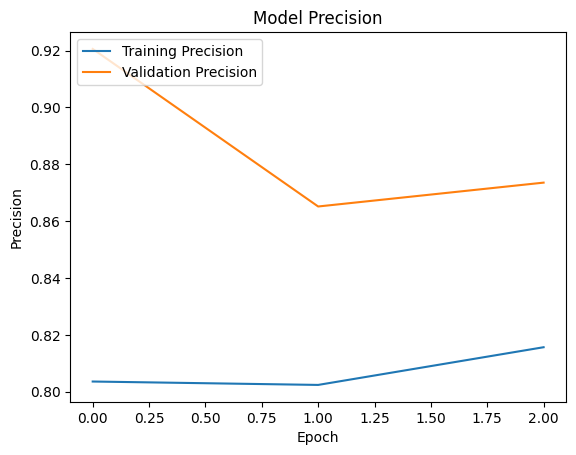

In [55]:
plt.plot(precision, label='Training Precision')
plt.plot(val_precision, label='Validation Precision')
plt.title('Model Precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

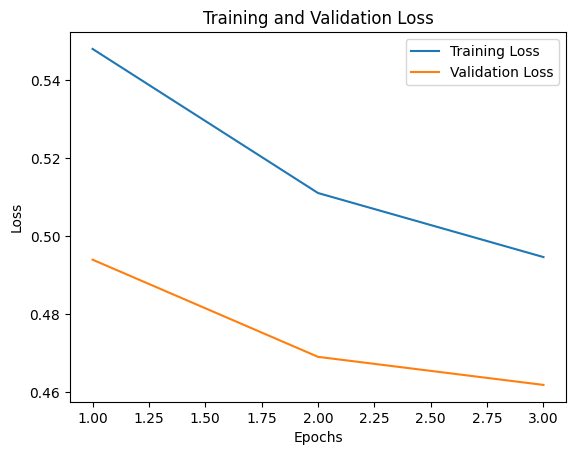

In [56]:
training_loss = history_stage2.history['loss']
validation_loss = history_stage2.history['val_loss']

epochs = range(1, len(training_loss) + 1)  # Epochs start from 1

plt.plot(epochs, training_loss, label='Training Loss')
plt.plot(epochs, validation_loss, label='Validation Loss')

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### Accuracy

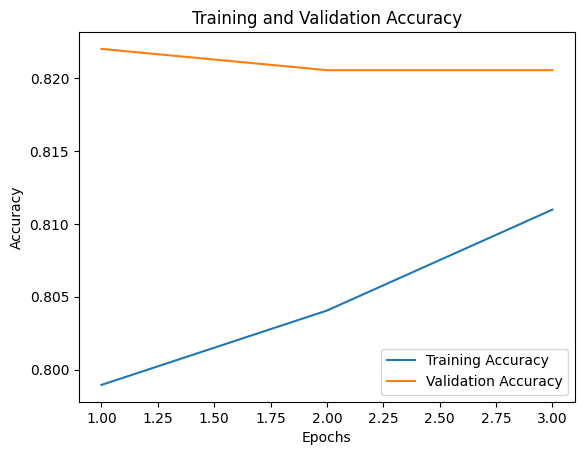

In [57]:
training_accuracy = history_stage2.history['accuracy']
validation_accuracy = history_stage2.history['val_accuracy']

epochs = range(1, len(training_accuracy) + 1)  # Epochs start from 1

plt.plot(epochs, training_accuracy, label='Training Accuracy')
plt.plot(epochs, validation_accuracy, label='Validation Accuracy')

plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### Confusion matrix
A confusion matrix provides a detailed breakdown of a classification model's performance, showing correct and incorrect predictions for each class. It helps identify specific misclassification patterns, such as whether the model is biased toward a certain class. Additionally, it is essential for calculating key metrics like precision, recall, and F1-score, which give deeper insights than accuracy alone.

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


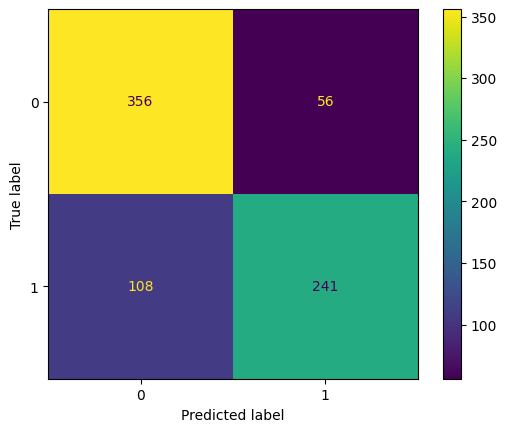

In [87]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

predictions_for_conf_mx = model.predict(train_df_conf_mx_padded)
predictions_for_conf_mx = (predictions_for_conf_mx > 0.5).astype(int)

actual = train_df_conf_mx['target']
predicted = predictions_for_conf_mx

confusion_matrix = metrics.confusion_matrix(actual, predicted)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])

cm_display.plot()
plt.show()

## Experiments with Dropout and Activation Functions
- adjusting dropout to 50% from 70% didn't significantly improve the model
- changing activation to relu from sigmoid didn't make a noticable difference
-